# Набор данных

In [ ]:
!pip install tensorflow
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import random

SEED = 42

np.random.seed(SEED)
random.seed(SEED)

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
idx = np.random.permutation(len(train_images)) # создаём случайную перестановку индексов и одинаково применяем её к изображениям и меткам
train_images = train_images[idx]
train_labels = train_labels[idx]
print(len(train_labels))
print(train_labels[0])
print(train_images[0].shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
60000
7
(28, 28)


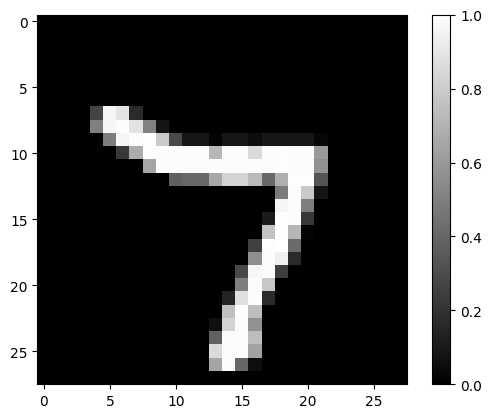

In [ ]:
# скейлим значения пикселей от 0 до 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# выводим пример картинки
plt.imshow(train_images[0], cmap='gray')
plt.colorbar()
plt.show()

# Модель

In [ ]:
def im2col(x, KH, KW, stride=1, pad=0):
    # x: входной тензор формы (N, C, H, W)
    # N — размер батча
    # C — количество каналов
    # H, W — высота и ширина изображения

    N, C, H, W = x.shape
    x_pad = np.pad(x, ((0,0),(0,0),(pad,pad),(pad,pad)), mode="constant")
    H_pad, W_pad = x_pad.shape[2], x_pad.shape[3]

    out_h = (H_pad - KH) // stride + 1
    out_w = (W_pad - KW) // stride + 1

    cols = np.empty((N, C, KH, KW, out_h, out_w), dtype=x.dtype)

    for kh in range(KH):
        h_slice = slice(kh, kh + stride*out_h, stride)
        for kw in range(KW):
            w_slice = slice(kw, kw + stride*out_w, stride)
            cols[:, :, kh, kw, :, :] = x_pad[:, :, h_slice, w_slice]

    cols = cols.transpose(0, 4, 5, 1, 2, 3).reshape(N, out_h*out_w, C*KH*KW)
    return cols, x_pad.shape, out_h, out_w


def col2im(cols, x_pad_shape, KH, KW, stride=1, pad=0):
    # cols: (N, L, C*KH*KW)
    # L = out_h * out_w

    N, C, H_pad, W_pad = x_pad_shape
    out_h = (H_pad - KH) // stride + 1
    out_w = (W_pad - KW) // stride + 1

    x_pad = np.zeros((N, C, H_pad, W_pad), dtype=cols.dtype)

    # возвращаем форму к (N, C, KH, KW, out_h, out_w)
    cols6 = cols.reshape(N, out_h, out_w, C, KH, KW).transpose(0, 3, 4, 5, 1, 2)

    for kh in range(KH):
        h_slice = slice(kh, kh + stride*out_h, stride)
        for kw in range(KW):
            w_slice = slice(kw, kw + stride*out_w, stride)
            x_pad[:, :, h_slice, w_slice] += cols6[:, :, kh, kw, :, :]

    if pad == 0:
        return x_pad
    return x_pad[:, :, pad:-pad, pad:-pad]


In [ ]:
class Linear:
  def __init__(self, w, b):
    # w: (in_features, out_features), b: (out_features,)
    self.w = w.astype(np.float32, copy=False)
    self.b = b.astype(np.float32, copy=False)
    self.z = None # выход до активации
    self.x = None # кэш входа для backward
    self.dw = None
    self.db = None

  def forward(self, x):
    # x: (N, in_features)
    self.x = x.astype(np.float32, copy=False)
    self.z = self.x @ self.w + self.b # (N, out_features)
    return self.z

  def backward(self, dz):
    # dz: (N, out_features)
    dz = dz.astype(np.float32, copy=False)
    dx = dz @ self.w.T # (N, in_features)
    self.dw = self.x.T @ dz # (in_features, out_features)
    self.db = np.sum(dz, axis=0, dtype=np.float32) # (out_features,)
    return dx

class LeakyReLU:
    def __init__(self, alpha=0.01):
        self.x = None
        self.alpha = np.float32(alpha)

    def forward(self, x):
        # сохраняем x, чтобы потом знать где была x < 0
        self.x = x.astype(np.float32, copy=False)
        return np.where(self.x > 0, self.x, self.alpha * self.x)

    def backward(self, dz):
        dz = dz.astype(np.float32, copy=False)

        # производная: 1 при x>0, alpha при x<0
        dx = np.ones_like(self.x, dtype=np.float32)
        dx[self.x < 0] = self.alpha
        return dz * dx

class Flatten:
  def __init__(self):
    self.shape = None

  def forward(self, x):
    # x: (N, C, H, W) -> (N, C*H*W)
    self.shape = x.shape
    x = x.astype(np.float32, copy=False)
    self.z = x.reshape(x.shape[0], -1)
    return self.z

  def backward(self, dz_flat):
    # dz_flat: (N, C*H*W) -> (N, C, H, W)
    dz_flat = dz_flat.astype(np.float32, copy=False)
    return dz_flat.reshape(self.shape)

class Conv2D:
    def __init__(self, w, b, stride, padding):
        # w: (C_out, C_in, K_h, K_w), b: (C_out,)
        self.w = w.astype(np.float32, copy=False)
        self.b = b.astype(np.float32, copy=False)
        self.stride = stride
        self.padding = padding

        self.x = None # кэш входа
        self.z = None
        self.dw = None
        self.db = None

        self.cols = None # im2col(x): (N, L, C_in*K_h*K_w)
        self.x_pad_shape = None # форма x после pad, нужна col2im
        self.out_h = None
        self.out_w = None

    def forward(self, x):
        # x: (N, C_in, H, W)
        x = x.astype(np.float32, copy=False)
        self.x = x

        C_out, C_in, K_h, K_w = self.w.shape

        # превращаем все окна K_h x K_w в строки
        cols, x_pad_shape, out_h, out_w = im2col(
            x, K_h, K_w, stride=self.stride, pad=self.padding
        )
        self.cols = cols.astype(np.float32, copy=False)
        self.x_pad_shape = x_pad_shape
        self.out_h, self.out_w = out_h, out_w

        # (C_out, C_in*K_h*K_w)
        W_row = self.w.reshape(C_out, -1)

        # (N, L, C_out): свёртка = матмул окон на фильтры + bias
        out = self.cols @ W_row.T + self.b.reshape(1, 1, -1)
        out = out.transpose(0, 2, 1).reshape(x.shape[0], C_out, out_h, out_w)

        # (N, C_out, out_h, out_w)
        self.z = out
        return out

    def backward(self, dz):
        # dz: (N, C_out, out_h, out_w)
        dz = dz.astype(np.float32, copy=False)

        N, C_out, out_h, out_w = dz.shape
        _, _, K_h, K_w = self.w.shape
        L = out_h * out_w

        # (N, L, C_out)
        dz2 = dz.reshape(N, C_out, L).transpose(0, 2, 1)

        # bias grad: суммируем по батчу и всем позициям
        self.db = dz2.sum(axis=(0, 1), dtype=np.float32) # (C_out,)

        # веса: dz * cols
        cols2 = self.cols.reshape(N * L, -1) # (N*L, K)
        dz2_flat = dz2.reshape(N * L, C_out) # (N*L, C_out)

        self.dw = (dz2_flat.T @ cols2).reshape(self.w.shape)

        # градиент по входу: dz * W
        W_row = self.w.reshape(C_out, -1) # (C_out, K)
        dcols = dz2_flat @ W_row # (N*L, K)
        dcols = dcols.reshape(N, L, -1) # (N, L, K)

        # собираем обратно в (N, C_in, H, W)
        dx = col2im(
            dcols.astype(np.float32, copy=False),
            self.x_pad_shape,
            K_h, K_w,
            stride=self.stride,
            pad=self.padding
        )
        return dx

class MaxPool2D:
    def __init__(self, pool_size, stride):
        self.pool_size = pool_size
        self.stride = stride

        self.x = None
        self.x_pad_shape = None
        self.out_h = None
        self.out_w = None

        self.cols = None
        self.argmax = None # где был максимум внутри каждого окна

    def forward(self, x):
        # x: (N, C, H, W)
        x = x.astype(np.float32, copy=False)
        self.x = x
        P = self.pool_size

        # вытаскиваем окна P x P так же через im2col
        cols, x_pad_shape, out_h, out_w = im2col(
            x, P, P, stride=self.stride, pad=0
        )

        cols = cols.astype(np.float32, copy=False)
        N, L, K = cols.shape
        C = x.shape[1]

        # (N, L, C, P*P): внутри каждого окна находим максимум
        cols_reshaped = cols.reshape(N, L, C, P * P)
        self.argmax = np.argmax(cols_reshaped, axis=3)
        out = np.max(cols_reshaped, axis=3) # (N, L, C)

        self.cols = cols
        self.x_pad_shape = x_pad_shape
        self.out_h, self.out_w = out_h, out_w

        # (N, C, out_h, out_w)
        return out.transpose(0, 2, 1).reshape(N, C, out_h, out_w)

    def backward(self, dz):
        # dz: (N, C, out_h, out_w)
        dz = dz.astype(np.float32, copy=False)

        N, C, out_h, out_w = dz.shape
        P = self.pool_size
        L = out_h * out_w

        # (N, L, C)
        dz2 = dz.reshape(N, C, L).transpose(0, 2, 1)

        # распределяем градиент только в позицию максимума (остальным 0)
        dcols = np.zeros((N, L, C, P * P), dtype=np.float32)

        n_idx = np.arange(N)[:, None, None]
        l_idx = np.arange(L)[None, :, None]
        c_idx = np.arange(C)[None, None, :]

        dcols[n_idx, l_idx, c_idx, self.argmax] = dz2

        dcols = dcols.reshape(N, L, C * P * P)

        # собираем обратно в форму входа
        dx = col2im(
            dcols,
            self.x_pad_shape,
            P, P,
            stride=self.stride,
            pad=0
        )
        return dx

In [ ]:
def softmax_and_cross_entropy(logits, y_true):
    # logits: (N, num_classes)
    # y_true: (N, num_classes) — one-hot метки

    # численная стабилизация:
    # вычитаем максимум в каждой строке,
    # чтобы exp() не улетел в бесконечность
    shifted = logits - np.max(logits, axis=1, keepdims=True)
    exp_scores = np.exp(shifted)

    # softmax: делим на сумму по классам
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # маленькая константа, чтобы не брать log(0)
    eps = 1e-12
    log_probs = np.log(probs + eps)

    # кросс энтропия
    loss = -np.sum(y_true * log_probs) / logits.shape[0]

    # градиент по логитам:
    # (softmax - one_hot) / N
    d_logits = (probs - y_true) / logits.shape[0]
    return probs, loss, d_logits


#Обучение


In [ ]:
def one_hot_encoding(y_true):
  # y_true: (N,) — метки классов 0..9
  # возвращаем one-hot: (N, 10)
  y_encoded = np.zeros((y_true.shape[0], 10))
  y_encoded[np.arange(y_true.shape[0]), y_true] = 1
  return y_encoded

In [ ]:
def forward(x, layers):
  # прямой проход: прогоняем x через все слои по порядку
  for layer in layers:
    x = layer.forward(x)
  return x

In [ ]:
def backward(dz, layers):
  # обратный проход: градиент идёт через слои в обратном порядке
  for layer in reversed(layers):
    dz = layer.backward(dz)
  return dz

In [ ]:
def grad_clip(layers, clip=5.0):
    # gradient clipping по норме: если ||grad|| > clip, масштабируем его
    # помогает от взрывов градиентов
    clip = float(clip)

    for layer in layers:
        # пропускаем слои без параметров
        if not hasattr(layer, "dw") or layer.dw is None:
            continue

        # клип по весам
        n = np.linalg.norm(layer.dw)
        if n > clip:
            layer.dw *= (clip / (n + 1e-12))

        # клип по bias
        if hasattr(layer, "db") and layer.db is not None:
            n = np.linalg.norm(layer.db)
            if n > clip:
                layer.db *= (clip / (n + 1e-12))

In [ ]:
class Momentum:
  def __init__(self, lr, u, layers):
    # lr — learning rate
    # u — коэффициент момента
    self.lr = lr
    self.u = u

    # state хранит скорости для каждого слоя
    # ключ = индекс слоя в списке layers
    self.state = {}

    for i, layer in enumerate(layers):
      # только слои с параметрами
      if hasattr(layer, 'w') and hasattr(layer, 'b'):
        self.state[i] = {
            'vw': np.zeros_like(layer.w),  # скорость для весов
            'vb': np.zeros_like(layer.b)   # скорость для bias
        }

  def step(self, layers):
    # один шаг оптимизации
    for i, layer in enumerate(layers):

      # если слой без параметров — пропускаем
      if i not in self.state:
        continue

      if layer.dw is None or layer.db is None:
        continue

      st = self.state[i]

      # обновление скорости:
      # v = u * v - lr * grad
      st['vw'] = self.u * st['vw'] - self.lr * layer.dw
      layer.w += st['vw']

      st['vb'] = self.u * st['vb'] - self.lr * layer.db
      layer.b += st['vb']

  def reset(self):
    for st in self.state.values():
      st['vw'].fill(0)
      st['vb'].fill(0)


#Процесс обучения

In [ ]:
epochs = 250
lr = 1e-3
batch_size = 64
u = 0.9

In [ ]:
conv_w = np.random.randn(10, 1, 3, 3) * np.sqrt(2 / (1*3*3))
conv_b = np.zeros(10)
conv = Conv2D(conv_w, conv_b, 1, 0)

leakyrelu1 = LeakyReLU()
maxpool = MaxPool2D(3, 1)
flatten = Flatten()

linear1_w = np.random.randn(5760, 10) * np.sqrt(2 / 5760)
linear1_b = np.zeros(10)
linear1 = Linear(np.random.randn(5760, 128), np.random.randn(128))

leakyrelu2 = LeakyReLU()

linear2_w = np.random.randn(10, 10) * np.sqrt(2 / 10)
linear2_b = np.zeros(10)
linear2 = Linear(np.random.randn(128, 10), np.random.randn(10))

layers = [conv, leakyrelu1, maxpool, flatten, linear1, leakyrelu2, linear2]

In [ ]:
momentum = Momentum(lr, u, layers)

In [ ]:
# Добавляем ось канала: (N, 28, 28) -> (N, 1, 28, 28)
x_all = train_images[:, None, :, :]

# One-hot кодирование меток
y_all = one_hot_encoding(train_labels)

# Перемешиваем датасет
idx = np.random.permutation(len(x_all))
x_all = x_all[idx]
y_all = y_all[idx]

# Делим 85% train, 15% validation
split = int(len(x_all) * 0.85)

x_train = x_all[:split]
y_train = y_all[:split]

val_images = x_all[split:]
val_labels = y_all[split:]

# Тестовые данные
x_test = test_images[:, None, :, :]
y_test = one_hot_encoding(test_labels)

In [ ]:
def accuracy(logits, y_true_onehot):
    # logits: (N, 10)
    # y_true_onehot: (N, 10)

    pred = np.argmax(logits, axis=1)         # предсказанные классы
    true = np.argmax(y_true_onehot, axis=1)  # реальные классы

    return np.mean(pred == true)             # доля правильных

In [17]:
from tqdm import tqdm
import copy

train_losses = []
val_accs = []

train_eval_size = 2000
target_acc = 0.95
patience = 3
hits = 0

lr_patience = 6
lr_wait = 0
lr_drop = 0.5
min_lr = 1e-5

min_delta = 0.002
lr_patience = 6
early_patience = 12
best_val = 1e-10

idx = np.random.permutation(len(x_all))
x_all = x_all[idx]
y_all = y_all[idx]

val_ratio = 0.1
split = int(len(x_all) * (1 - val_ratio))

x_train = x_all[:split]
y_train = y_all[:split]

x_val = x_all[split:]
y_val = y_all[split:]

eval_bs = 256

def accuracy_batched(x, y, layers, bs=256):
    if y.ndim == 2:
        y_labels = np.argmax(y, axis=1)
    else:
        y_labels = y

    correct = 0
    total = 0
    for i in range(0, len(x), bs):
        logits = forward(x[i:i+bs], layers)
        pred = np.argmax(logits, axis=1)
        correct += np.sum(pred == y_labels[i:i+bs])
        total += len(pred)
    return correct / total

for epoch in range(epochs):
    # перемешиваем train каждый epoch
    idx = np.random.permutation(len(x_train))
    sh_x = x_train[idx]
    sh_y = y_train[idx]

    epoch_loss = 0.0
    num_batches = len(sh_x) // batch_size

    for b in tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{epochs}"):
        s = b * batch_size
        e = s + batch_size
        x_batch = sh_x[s:e]
        y_batch = sh_y[s:e]

        logits = forward(x_batch, layers)
        probs, loss, d_logits = softmax_and_cross_entropy(logits, y_batch)

        backward(d_logits, layers)
        grad_clip(layers, clip=5.0) # защита от взрыва градиентов
        momentum.step(layers) # обновление весов

        epoch_loss += loss

    epoch_loss /= num_batches

    val_acc = accuracy_batched(x_val, y_val, layers, bs=eval_bs)

    train_idx = np.random.choice(len(x_train), size=train_eval_size, replace=False)
    x_tr_chk = x_train[train_idx]
    y_tr_chk = y_train[train_idx]

    train_acc = accuracy_batched(x_tr_chk, y_tr_chk, layers, bs=eval_bs)

    print(f"[Epoch {epoch+1}] loss={epoch_loss:.4f}, "
          f"train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")

    train_losses.append(float(epoch_loss))
    val_accs.append(float(val_acc))


    # early stopping: если долго нет улучшений - стопаем
    # lr reduce: уменьшаем lr, если val_acc не растёт
    if val_acc > best_val + min_delta:
        best_val = val_acc
        no_improve = 0
        lr_wait = 0
        best_layers = copy.deepcopy(layers)
    else:
        no_improve += 1
        lr_wait += 1

        if lr_wait >= lr_patience:
            momentum.lr = max(min_lr, momentum.lr * lr_drop)
            lr_wait = 0
            momentum.reset()
            print("LR reduced to", momentum.lr)

        if no_improve >= early_patience:
            print(f"Early stop: no improvement for {early_patience} epochs.")
            break


    if val_acc >= target_acc:
        hits += 1
        if hits >= patience:
            print(f"Reached {target_acc:.2%} for {patience} epochs. Stopping.")
            break
    else:
        hits = 0

Epoch 1/250: 100%|██████████| 843/843 [01:44<00:00,  8.07it/s]


[Epoch 1] loss=3.6968, train_acc=0.373, val_acc=0.374


Epoch 2/250: 100%|██████████| 843/843 [01:32<00:00,  9.13it/s]


[Epoch 2] loss=1.6957, train_acc=0.501, val_acc=0.505


Epoch 3/250: 100%|██████████| 843/843 [01:33<00:00,  9.02it/s]


[Epoch 3] loss=1.4136, train_acc=0.605, val_acc=0.601


Epoch 4/250: 100%|██████████| 843/843 [01:31<00:00,  9.26it/s]


[Epoch 4] loss=1.1795, train_acc=0.668, val_acc=0.669


Epoch 5/250: 100%|██████████| 843/843 [01:31<00:00,  9.24it/s]


[Epoch 5] loss=0.9901, train_acc=0.724, val_acc=0.728


Epoch 6/250: 100%|██████████| 843/843 [01:32<00:00,  9.14it/s]


[Epoch 6] loss=0.8470, train_acc=0.759, val_acc=0.763


Epoch 7/250: 100%|██████████| 843/843 [01:32<00:00,  9.09it/s]


[Epoch 7] loss=0.7403, train_acc=0.777, val_acc=0.789


Epoch 8/250: 100%|██████████| 843/843 [01:32<00:00,  9.15it/s]


[Epoch 8] loss=0.6603, train_acc=0.810, val_acc=0.809


Epoch 9/250: 100%|██████████| 843/843 [01:31<00:00,  9.17it/s]


[Epoch 9] loss=0.6006, train_acc=0.833, val_acc=0.826


Epoch 10/250: 100%|██████████| 843/843 [01:30<00:00,  9.29it/s]


[Epoch 10] loss=0.5520, train_acc=0.844, val_acc=0.839


Epoch 11/250: 100%|██████████| 843/843 [01:30<00:00,  9.31it/s]


[Epoch 11] loss=0.5147, train_acc=0.843, val_acc=0.850


Epoch 12/250: 100%|██████████| 843/843 [01:35<00:00,  8.80it/s]


[Epoch 12] loss=0.4841, train_acc=0.867, val_acc=0.857


Epoch 13/250: 100%|██████████| 843/843 [01:32<00:00,  9.07it/s]


[Epoch 13] loss=0.4593, train_acc=0.859, val_acc=0.861


Epoch 14/250: 100%|██████████| 843/843 [01:31<00:00,  9.17it/s]


[Epoch 14] loss=0.4386, train_acc=0.874, val_acc=0.868


Epoch 15/250: 100%|██████████| 843/843 [01:32<00:00,  9.16it/s]


[Epoch 15] loss=0.4204, train_acc=0.866, val_acc=0.872


Epoch 16/250: 100%|██████████| 843/843 [01:31<00:00,  9.22it/s]


[Epoch 16] loss=0.4047, train_acc=0.884, val_acc=0.873


Epoch 17/250: 100%|██████████| 843/843 [01:29<00:00,  9.43it/s]


[Epoch 17] loss=0.3911, train_acc=0.883, val_acc=0.879


Epoch 18/250: 100%|██████████| 843/843 [01:30<00:00,  9.30it/s]


[Epoch 18] loss=0.3789, train_acc=0.894, val_acc=0.882


Epoch 19/250: 100%|██████████| 843/843 [01:31<00:00,  9.25it/s]


[Epoch 19] loss=0.3678, train_acc=0.887, val_acc=0.887


Epoch 20/250: 100%|██████████| 843/843 [01:30<00:00,  9.26it/s]


[Epoch 20] loss=0.3578, train_acc=0.882, val_acc=0.889


Epoch 21/250: 100%|██████████| 843/843 [01:34<00:00,  8.95it/s]


[Epoch 21] loss=0.3489, train_acc=0.882, val_acc=0.891


Epoch 22/250: 100%|██████████| 843/843 [01:32<00:00,  9.11it/s]


[Epoch 22] loss=0.3404, train_acc=0.897, val_acc=0.891


Epoch 23/250: 100%|██████████| 843/843 [01:31<00:00,  9.24it/s]


[Epoch 23] loss=0.3332, train_acc=0.896, val_acc=0.894


Epoch 24/250: 100%|██████████| 843/843 [01:30<00:00,  9.28it/s]


[Epoch 24] loss=0.3261, train_acc=0.893, val_acc=0.895


Epoch 25/250: 100%|██████████| 843/843 [01:29<00:00,  9.38it/s]


[Epoch 25] loss=0.3192, train_acc=0.916, val_acc=0.899


Epoch 26/250: 100%|██████████| 843/843 [01:32<00:00,  9.14it/s]


[Epoch 26] loss=0.3134, train_acc=0.911, val_acc=0.902


Epoch 27/250: 100%|██████████| 843/843 [01:30<00:00,  9.27it/s]


[Epoch 27] loss=0.3075, train_acc=0.898, val_acc=0.902


Epoch 28/250: 100%|██████████| 843/843 [01:31<00:00,  9.18it/s]


[Epoch 28] loss=0.3020, train_acc=0.913, val_acc=0.902


Epoch 29/250: 100%|██████████| 843/843 [01:32<00:00,  9.12it/s]


[Epoch 29] loss=0.2972, train_acc=0.908, val_acc=0.903


Epoch 30/250: 100%|██████████| 843/843 [01:31<00:00,  9.26it/s]


[Epoch 30] loss=0.2926, train_acc=0.922, val_acc=0.906


Epoch 31/250: 100%|██████████| 843/843 [01:31<00:00,  9.18it/s]


[Epoch 31] loss=0.2880, train_acc=0.915, val_acc=0.907


Epoch 32/250: 100%|██████████| 843/843 [01:32<00:00,  9.09it/s]


[Epoch 32] loss=0.2838, train_acc=0.917, val_acc=0.907


Epoch 33/250: 100%|██████████| 843/843 [01:33<00:00,  9.05it/s]


[Epoch 33] loss=0.2798, train_acc=0.915, val_acc=0.908


Epoch 34/250: 100%|██████████| 843/843 [01:32<00:00,  9.15it/s]


[Epoch 34] loss=0.2758, train_acc=0.923, val_acc=0.908


Epoch 35/250: 100%|██████████| 843/843 [01:33<00:00,  8.97it/s]


[Epoch 35] loss=0.2716, train_acc=0.923, val_acc=0.910


Epoch 36/250: 100%|██████████| 843/843 [01:33<00:00,  9.05it/s]


[Epoch 36] loss=0.2680, train_acc=0.923, val_acc=0.911


Epoch 37/250: 100%|██████████| 843/843 [01:32<00:00,  9.15it/s]


[Epoch 37] loss=0.2651, train_acc=0.928, val_acc=0.913


Epoch 38/250: 100%|██████████| 843/843 [01:32<00:00,  9.16it/s]


[Epoch 38] loss=0.2617, train_acc=0.918, val_acc=0.915


Epoch 39/250: 100%|██████████| 843/843 [01:31<00:00,  9.23it/s]


[Epoch 39] loss=0.2587, train_acc=0.920, val_acc=0.917


Epoch 40/250: 100%|██████████| 843/843 [01:30<00:00,  9.27it/s]


[Epoch 40] loss=0.2558, train_acc=0.921, val_acc=0.917


Epoch 41/250: 100%|██████████| 843/843 [01:29<00:00,  9.38it/s]


[Epoch 41] loss=0.2529, train_acc=0.928, val_acc=0.916


Epoch 42/250: 100%|██████████| 843/843 [01:33<00:00,  8.99it/s]


[Epoch 42] loss=0.2500, train_acc=0.925, val_acc=0.919


Epoch 43/250: 100%|██████████| 843/843 [01:33<00:00,  8.99it/s]


[Epoch 43] loss=0.2473, train_acc=0.930, val_acc=0.918


Epoch 44/250: 100%|██████████| 843/843 [01:33<00:00,  9.05it/s]


[Epoch 44] loss=0.2444, train_acc=0.917, val_acc=0.920


Epoch 45/250: 100%|██████████| 843/843 [01:32<00:00,  9.12it/s]


[Epoch 45] loss=0.2421, train_acc=0.928, val_acc=0.921


Epoch 46/250: 100%|██████████| 843/843 [01:31<00:00,  9.21it/s]


[Epoch 46] loss=0.2393, train_acc=0.921, val_acc=0.922


Epoch 47/250: 100%|██████████| 843/843 [01:32<00:00,  9.15it/s]


[Epoch 47] loss=0.2377, train_acc=0.929, val_acc=0.924


Epoch 48/250: 100%|██████████| 843/843 [01:32<00:00,  9.13it/s]


[Epoch 48] loss=0.2352, train_acc=0.933, val_acc=0.925


Epoch 49/250: 100%|██████████| 843/843 [01:32<00:00,  9.12it/s]


[Epoch 49] loss=0.2332, train_acc=0.929, val_acc=0.924


Epoch 50/250: 100%|██████████| 843/843 [01:33<00:00,  9.05it/s]


[Epoch 50] loss=0.2310, train_acc=0.924, val_acc=0.926


Epoch 51/250: 100%|██████████| 843/843 [01:32<00:00,  9.11it/s]


[Epoch 51] loss=0.2287, train_acc=0.932, val_acc=0.927


Epoch 52/250: 100%|██████████| 843/843 [01:32<00:00,  9.07it/s]


[Epoch 52] loss=0.2265, train_acc=0.938, val_acc=0.927


Epoch 53/250: 100%|██████████| 843/843 [01:33<00:00,  9.02it/s]


[Epoch 53] loss=0.2251, train_acc=0.928, val_acc=0.929


Epoch 54/250: 100%|██████████| 843/843 [01:33<00:00,  8.99it/s]


[Epoch 54] loss=0.2232, train_acc=0.943, val_acc=0.929


Epoch 55/250: 100%|██████████| 843/843 [01:34<00:00,  8.92it/s]


[Epoch 55] loss=0.2215, train_acc=0.936, val_acc=0.929


Epoch 56/250: 100%|██████████| 843/843 [01:33<00:00,  8.98it/s]


[Epoch 56] loss=0.2195, train_acc=0.926, val_acc=0.930


Epoch 57/250: 100%|██████████| 843/843 [01:34<00:00,  8.96it/s]


[Epoch 57] loss=0.2175, train_acc=0.929, val_acc=0.932


Epoch 58/250: 100%|██████████| 843/843 [01:33<00:00,  9.05it/s]


[Epoch 58] loss=0.2160, train_acc=0.931, val_acc=0.931


Epoch 59/250: 100%|██████████| 843/843 [01:32<00:00,  9.10it/s]


[Epoch 59] loss=0.2145, train_acc=0.928, val_acc=0.931


Epoch 60/250: 100%|██████████| 843/843 [01:32<00:00,  9.07it/s]


[Epoch 60] loss=0.2128, train_acc=0.935, val_acc=0.934


Epoch 61/250: 100%|██████████| 843/843 [01:32<00:00,  9.14it/s]


[Epoch 61] loss=0.2111, train_acc=0.931, val_acc=0.933


Epoch 62/250: 100%|██████████| 843/843 [01:31<00:00,  9.19it/s]


[Epoch 62] loss=0.2096, train_acc=0.932, val_acc=0.933


Epoch 63/250: 100%|██████████| 843/843 [01:31<00:00,  9.24it/s]


[Epoch 63] loss=0.2081, train_acc=0.938, val_acc=0.934


Epoch 64/250: 100%|██████████| 843/843 [01:31<00:00,  9.18it/s]


[Epoch 64] loss=0.2067, train_acc=0.940, val_acc=0.933


Epoch 65/250: 100%|██████████| 843/843 [01:31<00:00,  9.20it/s]


[Epoch 65] loss=0.2055, train_acc=0.934, val_acc=0.937


Epoch 66/250: 100%|██████████| 843/843 [01:32<00:00,  9.09it/s]


[Epoch 66] loss=0.2037, train_acc=0.943, val_acc=0.936


Epoch 67/250: 100%|██████████| 843/843 [01:32<00:00,  9.08it/s]


[Epoch 67] loss=0.2023, train_acc=0.942, val_acc=0.936


Epoch 68/250: 100%|██████████| 843/843 [01:32<00:00,  9.10it/s]


[Epoch 68] loss=0.2012, train_acc=0.934, val_acc=0.937


Epoch 69/250: 100%|██████████| 843/843 [01:32<00:00,  9.13it/s]


[Epoch 69] loss=0.1997, train_acc=0.938, val_acc=0.939


Epoch 70/250: 100%|██████████| 843/843 [01:32<00:00,  9.13it/s]


[Epoch 70] loss=0.1984, train_acc=0.939, val_acc=0.938


Epoch 71/250: 100%|██████████| 843/843 [01:34<00:00,  8.96it/s]


[Epoch 71] loss=0.1971, train_acc=0.939, val_acc=0.936


Epoch 72/250: 100%|██████████| 843/843 [01:32<00:00,  9.09it/s]


[Epoch 72] loss=0.1961, train_acc=0.936, val_acc=0.937


Epoch 73/250: 100%|██████████| 843/843 [01:33<00:00,  8.98it/s]


[Epoch 73] loss=0.1949, train_acc=0.940, val_acc=0.940


Epoch 74/250: 100%|██████████| 843/843 [01:30<00:00,  9.27it/s]


[Epoch 74] loss=0.1937, train_acc=0.939, val_acc=0.940


Epoch 75/250: 100%|██████████| 843/843 [01:33<00:00,  9.01it/s]


[Epoch 75] loss=0.1927, train_acc=0.935, val_acc=0.939
LR reduced to 0.0005


Epoch 76/250: 100%|██████████| 843/843 [01:32<00:00,  9.14it/s]


[Epoch 76] loss=0.1907, train_acc=0.947, val_acc=0.940


Epoch 77/250: 100%|██████████| 843/843 [01:31<00:00,  9.18it/s]


[Epoch 77] loss=0.1903, train_acc=0.940, val_acc=0.941


Epoch 78/250: 100%|██████████| 843/843 [01:32<00:00,  9.11it/s]


[Epoch 78] loss=0.1895, train_acc=0.943, val_acc=0.940


Epoch 79/250: 100%|██████████| 843/843 [01:32<00:00,  9.10it/s]


[Epoch 79] loss=0.1891, train_acc=0.948, val_acc=0.939


Epoch 80/250: 100%|██████████| 843/843 [01:32<00:00,  9.10it/s]


[Epoch 80] loss=0.1885, train_acc=0.940, val_acc=0.940


Epoch 81/250: 100%|██████████| 843/843 [01:32<00:00,  9.13it/s]


[Epoch 81] loss=0.1880, train_acc=0.940, val_acc=0.939
LR reduced to 0.00025
Early stop: no improvement for 12 epochs.


#Метрики и результаты

In [18]:
def to_labels(y):
    return np.argmax(y, axis=1) if y.ndim == 2 else y

def predict_labels_batched(x, layers, bs=256):
    preds = []
    for i in range(0, len(x), bs):
        logits = forward(x[i:i+bs], layers)          # (batch, 10)
        preds.append(np.argmax(logits, axis=1))      # (batch,)
    return np.concatenate(preds, axis=0)             # (N,)

y_test_lbl = to_labels(y_test)
y_pred = predict_labels_batched(x_test, layers, bs=256)

test_acc = (y_pred == y_test_lbl).mean()
print("FULL test_acc:", float(test_acc))

FULL test_acc: 0.9495


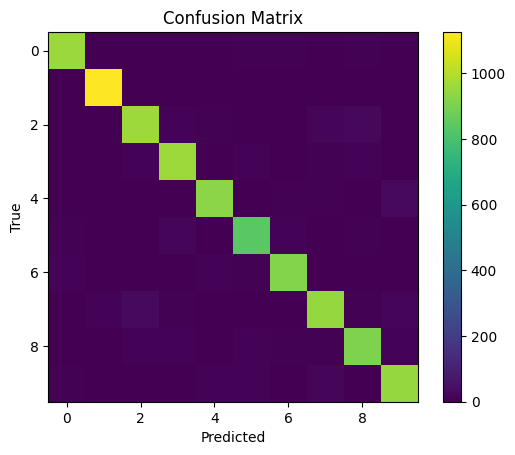

In [19]:
def confusion_matrix(y_true, y_pred, num_classes=None):
    # Строим матрицу ошибок cm[true, pred]
    # где cm[i,j] = сколько раз класс i предсказали как j
    if num_classes is None:
        num_classes = int(max(y_true.max(), y_pred.max())) + 1
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    np.add.at(cm, (y_true, y_pred), 1)
    return cm

cm = confusion_matrix(y_test_lbl, y_pred, num_classes=10)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

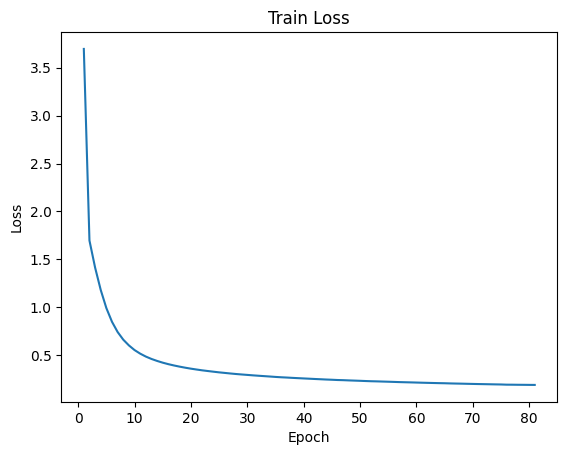

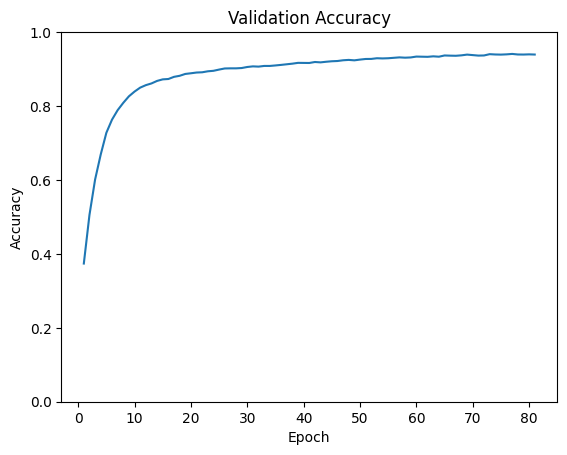

In [20]:
epochs_ran = np.arange(1, len(train_losses) + 1)

plt.figure()
plt.plot(epochs_ran, train_losses)
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(epochs_ran, val_accs)
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.show()

Wrong predictions: 505


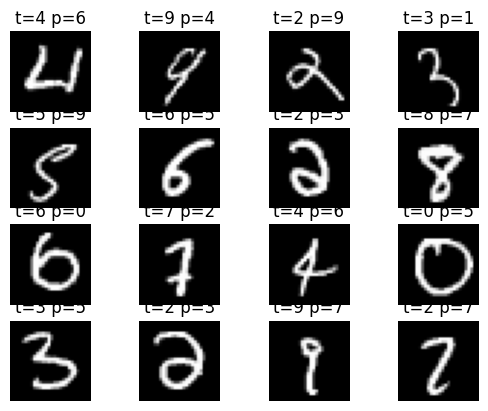

In [21]:
wrong = np.where(y_pred != y_test_lbl)[0]
print("Wrong predictions:", len(wrong))

k = min(16, len(wrong))
idxs = wrong[:k]

plt.figure()
for i, idx in enumerate(idxs):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_test[idx, 0], cmap="gray")
    plt.title(f"t={y_test_lbl[idx]} p={y_pred[idx]}")
    plt.axis("off")
plt.show()